In [1]:
import pydicom
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from IPython.display import display_html

In [2]:
from transformers import ViTImageProcessor
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)
from torch.utils.data import DataLoader
import torch


from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import numpy as np
import torch

/Users/jasetran/Library/CloudStorage/OneDrive-UniversityofManitoba/Projects/rsna-cancer-detection-1/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Dataset

### Baseline Model

In [3]:
from transformers import ViTImageProcessor
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)
from torch.utils.data import DataLoader
import torch

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [RandomResizedCrop(size), RandomHorizontalFlip(), ToTensor(), normalize,]
    )

_val_transforms = Compose(
        [Resize(size), CenterCrop(size), ToTensor(), normalize,]
    )

# train_ds.set_transform(train_transforms)
# val_ds.set_transform(val_transforms)
# test_ds.set_transform(val_transforms)

# train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [4]:
from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import numpy as np
import torch



# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
#                                                   id2label=id2label,
#                                                   label2id=label2id)

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))


# trainer = Trainer(
#     model,
#     args,
#     train_dataset=train_ds,
#     eval_dataset=val_ds,
#     data_collator=collate_fn,
#     compute_metrics=compute_metrics,
#     tokenizer=processor,
# )

# trainer.train()


In [6]:
# outputs = trainer.predict(test_ds)
# print(outputs.metrics)

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# y_true = outputs.label_ids
# y_pred = outputs.predictions.argmax(1)

# labels = train_ds.features['label'].names
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(xticks_rotation=45)

### Idea 1: Embed tabular data into the image

Create 16x16 image patch and embed in source image 

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2


from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50
from time import time
import datetime as dtime
from tqdm import tqdm
import gc

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [8]:
def read_img(path):
    if path.endswith('.dcm'):
        img = pydicom.dcmread(path).pixel_array
    else:
        img = np.array(Image.open(path))
    return img

def plot_img(img,ax=plt,cmap='turbo'):
    ax.axis("off")
    ax.imshow(img, cmap=cmap)

In [9]:
class RSNADataset(Dataset):
    def __init__(self,dataframe,columns=None,vertical_flip=0.5, horizontal_flip=0.5,is_train=True) -> None:
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        if columns is None:
            self.columns = ['laterality','view','age','biopsy','invasive','BIRADS','implant','density']
        else:
            self.columns = columns
        if is_train:
            self.transform = Compose([
                                      RandomResizedCrop(height=224, width=224),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit = [0.8, 1.2]),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      ToTensorV2()])
        else:
            self.transform = Compose([ToTensorV2()])

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self,index):
        image_entry = self.dataframe.iloc[index]
        metadata = torch.tensor(image_entry.loc[self.columns]).type(torch.float32)
        image = read_img(image_entry.loc['path']).astype(np.float32)
        image_trf = self.transform(image = image)['image'].tile((3,1,1))
        label = self.dataframe.iloc[index]['cancer']
        return image_trf,label,metadata

In [23]:
from sklearn.model_selection import train_test_split

data_samples = pd.read_csv('train_samples_1.csv').set_index('Unnamed: 0')
data_samples.index.name = 'index'
train_samples, test_samples = train_test_split(data_samples, 
                                               test_size = 0.25, 
                                               stratify = data_samples['cancer'])
data = train_samples
dataset = RSNADataset(data, vertical_flip=0.5, horizontal_flip=0.5,is_train=True)
dataloader = DataLoader(dataset, batch_size=6, shuffle=False)

In [24]:
X,y,meta = next(iter(dataloader))
X.shape,y.shape,meta.shape

(torch.Size([6, 3, 224, 224]), torch.Size([6]), torch.Size([6, 8]))

In [ ]:
# plot_img(X[0,0],cmap='Greys_r')

In [25]:
class ViT1(nn.Module):
    def __init__(self,meta_size=8, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.ViT = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k') # 1000 neurons out
        self.expand = nn.Linear(meta_size, 16*16)
        # self.classification = nn.Linear(1000,1)

    def forward(self,X,meta=None):
        if meta is not None:
            patch =  self.expand(meta).tile((3,1,1)).reshape((X.shape[0],3,16,16))
            X[:,:,-16:,-16:] = patch
        output = self.ViT(X)
        return output
    
model = ViT1()


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


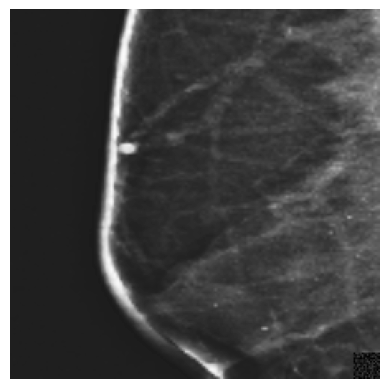

In [26]:
# patch = model.expand(meta).tile((3,1,1)).reshape((X.shape[0],3,16,16))
# a = X.clone()
# a[:,:,-16:,-16:] = patch
# plot_img(a[0,0].detach().numpy(),cmap='Greys_r')

In [ ]:
# model = ViT1()
# out = model(X,meta)
# out

In [28]:
def train_model_1(model,data):
    vertical_flip = 0.5
    horizontal_flip = 0.5
    FOLDS = 3
    EPOCHS = 10
    PATIENCE = 5
    WORKERS = 8
    LR = 0.0005
    WD = 0.0
    LR_PATIENCE = 1            # 1 model not improving until lr is decreasing
    LR_FACTOR = 0.4            # by how much the lr is decreasing
    BATCH_SIZE1 = 16           # for train
    BATCH_SIZE2 = 8           # for valid
    patience_f = PATIENCE

    group_fold = StratifiedGroupKFold(n_splits = FOLDS)
    k_folds = group_fold.split(X = np.zeros(len(data)), 
                                y = data['cancer'], 
                                groups = data['patient_id'].tolist())

    for i, (train_index, valid_index) in enumerate(k_folds):
        best_roc = None
        # Reset patience before every fold
        patience_f = PATIENCE
        # Optimizer/ Scheduler/ Criterion
        optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=WD)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=LR_PATIENCE, verbose=True, factor=LR_FACTOR)
        criterion = nn.BCEWithLogitsLoss()

        train_data = data.iloc[train_index].reset_index(drop=True)
        valid_data = data.iloc[valid_index].reset_index(drop=True)
        train = RSNADataset(train_data, None, vertical_flip, horizontal_flip, is_train=True)
        valid = RSNADataset(valid_data, None, vertical_flip, horizontal_flip, is_train=True)
        train_loader = DataLoader(train, batch_size=BATCH_SIZE1, shuffle=True ) # num_workers=WORKERS
        valid_loader = DataLoader(valid, batch_size=BATCH_SIZE2, shuffle=False) # num_workers=WORKERS

        # === EPOCHS ===
        for epoch in range(EPOCHS):
            start_time = time()
            correct = 0
            train_losses = 0

            # === TRAIN ===
            model.train()
            desc = f"Epoch {epoch+1}/{EPOCHS} - training"
            tqdm_loader = tqdm(enumerate(train_loader),total=len(train_loader),desc = desc, unit = f'batch-of-{BATCH_SIZE1}')
            for k, (X,y,meta) in tqdm_loader:
                # Save them to device
                # Clear gradients first; very important
                # usually done BEFORE prediction
                optimizer.zero_grad()
                # Log Probabilities & Backpropagation
                out = model(X,meta=meta)
                loss = criterion(out, y.unsqueeze(1).float())
                loss.backward()
                optimizer.step()

                train_losses += loss.item()
                # From log probabilities to actual probabilities
                # train_preds = torch.round(torch.sigmoid(out)) # 0 and 1
                train_preds = torch.argmax(out)
                # Number of correct predictions
                correct += (train_preds == y.unsqueeze(1)).sum().item()
                
            train_acc = correct / len(train_index)
            # print({"train_acc": train_acc})

            # === EVAL ===
            # Sets the model in evaluation mode.
            model.eval()
            # Create matrix to store evaluation predictions (for accuracy)
            valid_preds = torch.zeros(size = (len(valid_index), 1), dtype=torch.float32)

            # Disables gradients (we need to be sure no optimization happens)
            with torch.no_grad():
                desc = f"Epoch {epoch+1}/{EPOCHS} - validation"
                tqdm_loader = tqdm(enumerate(valid_loader),total=len(valid_loader),desc=desc, unit = f'batch-of-{BATCH_SIZE2}')
                for k, (X,y,meta) in tqdm_loader:
                    # Save them to device
                    out = model(X,meta=meta)
                    pred = torch.sigmoid(out)
                    valid_preds[k*X.shape[0] : k*X.shape[0] + X.shape[0]] = pred

                # Calculate accuracy
                valid_acc = accuracy_score(valid_data['cancer'].values, torch.round(valid_preds.cpu()))
                # Calculate ROC
                valid_roc = roc_auc_score(valid_data['cancer'].values, valid_preds.cpu())

                # Calculate time on Train + Eval
                duration = str(dtime.timedelta(seconds=time() - start_time))[:7]


                # PRINT INFO
                final_logs = '{} | Epoch: {}/{} | Loss: {:.4} | Acc_tr: {:.3} | Acc_vd: {:.3} | ROC: {:.3}'.\
                                format(duration, epoch+1, EPOCHS, 
                                        train_losses, train_acc, valid_acc, valid_roc)
                print(final_logs)

                # === SAVE MODEL ===

                # Update scheduler (for learning_rate)
                scheduler.step(valid_roc)
                # Name the model
                model_name = f"Fold{i+1}_Epoch{epoch+1}_ValidAcc{valid_acc:.3f}_ROC{valid_roc:.3f}.pth"

                # Update best_roc
                if best_roc is None: # If best_roc = None
                    best_roc = valid_roc
                    torch.save(model.state_dict(), model_name)
                    continue

                if valid_roc > best_roc:
                    best_roc = valid_roc
                    # Reset patience (because we have improvement)
                    patience_f = PATIENCE
                    torch.save(model.state_dict(), model_name)
                else:
                    # Decrease patience (no improvement in ROC)
                    patience_f = patience_f - 1
                    if patience_f == 0:
                        stop_logs = 'Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                                    format(best_roc)
                        print(stop_logs)
                        break
        del X,y,train_data,valid_data,train,valid,train_loader,valid_loader
        gc.collect()    

train_model_1(model,train_samples)

Epoch 1/10 - training:   0%|          | 0/10 [00:06<?, ?batch-of-16/s]


AttributeError: 'ImageClassifierOutput' object has no attribute 'size'

### Idea 2: Use secondary NN to learn from ViT prediction + tabular data

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2


from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50
from time import time
import datetime as dtime
from tqdm import tqdm
import gc

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [ ]:
def train_model_2(model,data):
    vertical_flip = 0.5
    horizontal_flip = 0.5

    FOLDS = 3
    EPOCHS = 10
    PATIENCE = 5
    WORKERS = 8
    LR = 0.0005
    WD = 0.0
    LR_PATIENCE = 1            # 1 model not improving until lr is decreasing
    LR_FACTOR = 0.4            # by how much the lr is decreasing

    BATCH_SIZE1 = 16           # for train
    BATCH_SIZE2 = 8           # for valid

    patience_f = PATIENCE


    group_fold = StratifiedGroupKFold(n_splits = FOLDS)
    k_folds = group_fold.split(X = np.zeros(len(data)), 
                                y = data['cancer'], 
                                groups = data['patient_id'].tolist())

    for i, (train_index, valid_index) in enumerate(k_folds):
        best_roc = None
        # Reset patience before every fold
        patience_f = PATIENCE

        # Optimizer/ Scheduler/ Criterion
        optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=WD)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=LR_PATIENCE, verbose=True, factor=LR_FACTOR)
        criterion = nn.BCEWithLogitsLoss()

        train_data = data.iloc[train_index].reset_index(drop=True)
        valid_data = data.iloc[valid_index].reset_index(drop=True)
        train = RSNADataset(train_data, vertical_flip, horizontal_flip, is_train=True)
        valid = RSNADataset(valid_data, vertical_flip, horizontal_flip, is_train=True)
        train_loader = DataLoader(train, batch_size=BATCH_SIZE1, shuffle=True ) # num_workers=WORKERS
        valid_loader = DataLoader(valid, batch_size=BATCH_SIZE2, shuffle=False) # num_workers=WORKERS

        # === EPOCHS ===
        for epoch in range(EPOCHS):
            start_time = time()
            correct = 0
            train_losses = 0

            # === TRAIN ===
            model.train()
            desc = f"Epoch {epoch+1}/{EPOCHS} - training"
            tqdm_loader = tqdm(enumerate(train_loader),total=len(train_loader),desc = desc, unit = f'batch-of-{BATCH_SIZE1}')
            for k, (X,y,meta) in tqdm_loader:
                # Save them to device
                # Clear gradients first; very important
                # usually done BEFORE prediction
                optimizer.zero_grad()
                # Log Probabilities & Backpropagation
                out = model(X)
                loss = criterion(out, y.unsqueeze(1).float())
                loss.backward()
                optimizer.step()

                train_losses += loss.item()
                # From log probabilities to actual probabilities
                train_preds = torch.round(torch.sigmoid(out)) # 0 and 1
                # Number of correct predictions
                correct += (train_preds == y.unsqueeze(1)).sum().item()
                
            train_acc = correct / len(train_index)
            # print({"train_acc": train_acc})

            # === EVAL ===
            # Sets the model in evaluation mode.
            model.eval()
            # Create matrix to store evaluation predictions (for accuracy)
            valid_preds = torch.zeros(size = (len(valid_index), 1), dtype=torch.float32)

            # Disables gradients (we need to be sure no optimization happens)
            with torch.no_grad():
                desc = f"Epoch {epoch+1}/{EPOCHS} - validation"
                tqdm_loader = tqdm(enumerate(valid_loader),total=len(valid_loader),desc=desc, unit = f'batch-of-{BATCH_SIZE2}')
                for k, (X,y,meta) in tqdm_loader:
                    # Save them to device
                    out = model(X)
                    pred = torch.sigmoid(out)
                    valid_preds[k*X.shape[0] : k*X.shape[0] + X.shape[0]] = pred

                # Calculate accuracy
                valid_acc = accuracy_score(valid_data['cancer'].values, torch.round(valid_preds.cpu()))
                # Calculate ROC
                valid_roc = roc_auc_score(valid_data['cancer'].values, valid_preds.cpu())

                # Calculate time on Train + Eval
                duration = str(dtime.timedelta(seconds=time() - start_time))[:7]


                # PRINT INFO
                final_logs = '{} | Epoch: {}/{} | Loss: {:.4} | Acc_tr: {:.3} | Acc_vd: {:.3} | ROC: {:.3}'.\
                                format(duration, epoch+1, EPOCHS, 
                                        train_losses, train_acc, valid_acc, valid_roc)
                print(final_logs)

                # === SAVE MODEL ===

                # Update scheduler (for learning_rate)
                scheduler.step(valid_roc)
                # Name the model
                model_name = f"Fold{i+1}_Epoch{epoch+1}_ValidAcc{valid_acc:.3f}_ROC{valid_roc:.3f}.pth"

                # Update best_roc
                if best_roc is None: # If best_roc = None
                    best_roc = valid_roc
                    torch.save(model.state_dict(), model_name)
                    continue

                if valid_roc > best_roc:
                    best_roc = valid_roc
                    # Reset patience (because we have improvement)
                    patience_f = PATIENCE
                    torch.save(model.state_dict(), model_name)
                else:
                    # Decrease patience (no improvement in ROC)
                    patience_f = patience_f - 1
                    if patience_f == 0:
                        stop_logs = 'Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                                    format(best_roc)
                        print(stop_logs)
                        break
        del X,y,train_data,valid_data,train,valid,train_loader,valid_loader
        gc.collect()

train_model_2(model,train_samples)    

### Idea 3: Predict Difficult Cases